In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
df_train = pd.read_csv("titanic_dataset/train.csv")
df_test = pd.read_csv("titanic_dataset/test.csv")
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
combine = [df_train,df_test]

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### DATA PREVIEW

In [4]:
print("Number of train examples: ",df_train.shape[0])
print("Number of test examples: ",df_test.shape[0])
print("Train data shape: ",df_train.shape)
print("Test data shape: ",df_test.shape)

Number of train examples:  891
Number of test examples:  418
Train data shape:  (891, 12)
Test data shape:  (418, 11)


### EDA

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


##### Which features are categorical?
- Sex, Embarked, Pclass


##### Which features are numerical?
- Continuous: Age,Fare
- Discrete: SibSp,Parch

##### Which features are alphanumerical?
- Ticket,Cabin

### Missing Values

In [6]:
for df in combine:
    for col in df.columns.tolist():
        print("{} column missing values: {}".format(col,df[col].isnull().sum()))
    print("\n")
    

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [66]:
corr = df_all.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,Age,Embarked_1,Embarked_2,Embarked_3,Fare,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,SibSp
Age,1.000000,0.080723,0.117423,0.003489,0.244320,0.099165,0.428827,0.053330,0.414760,0.056726,0.056726,0.181026
Embarked_1,0.080723,1.000000,0.164166,0.778262,0.217734,0.008635,0.325722,0.134675,0.171430,0.066564,0.066564,0.048396
Embarked_2,0.117423,0.164166,1.000000,0.491656,0.267402,0.100943,0.166101,0.121973,0.243706,0.088651,0.088651,0.048678
Embarked_3,0.003489,0.778262,0.491656,1.000000,0.021986,0.071881,0.181800,0.196532,0.003805,0.115193,0.115193,0.073709
Fare,0.244320,0.217734,0.267402,0.021986,1.000000,0.355646,0.651767,0.087108,0.635347,0.246767,0.246767,0.360118
Parch,0.099165,0.008635,0.100943,0.071881,0.355646,1.000000,0.013033,0.010057,0.019521,0.213125,0.213125,0.373587
Pclass_1,0.428827,0.325722,0.166101,0.181800,0.651767,0.013033,1.000000,0.296526,0.622172,0.107371,0.107371,0.034256
Pclass_2,0.053330,0.134675,0.121973,0.196532,0.087108,0.010057,0.296526,1.000000,0.563180,0.028862,0.028862,0.052419
Pclass_3,0.414760,0.171430,0.243706,0.003805,0.635347,0.019521,0.622172,0.563180,1.000000,0.116562,0.116562,0.072610
Sex_1,0.056726,0.066564,0.088651,0.115193,0.246767,0.213125,0.107371,0.028862,0.116562,1.000000,1.000000,0.109609


#### Age

In [10]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [12]:
age_by_pclass = df_all.groupby(['Pclass']).median()['Age']
print(age_by_pclass)

#filling the missing values
df_all['Age'] = df_all.groupby(['Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Pclass
1    39.0
2    29.0
3    24.0
Name: Age, dtype: float64


In [13]:
df_all['Age'].isnull().sum()

0

#### Fare

In [14]:
df_all['Fare'].isnull().sum()

1

In [15]:
df_all['Fare'].fillna(df_all['Fare'].median(),inplace = True)

In [16]:
df_all['Fare'].isnull().sum()

0

#### Embarked

In [17]:
df_all['Embarked'].isnull().sum()

2

In [18]:
freq_embarked = df_all.Embarked.dropna().mode()[0]
freq_embarked

'S'

In [19]:
df_all['Embarked'] = df_all['Embarked'].fillna(freq_embarked)

In [20]:
df_all['Embarked'].isnull().sum()

0

#### Ticket,Cabin,Name

In [21]:
df_all = df_all.drop(['Ticket','Cabin','Name'],axis= 1)

In [22]:
df_all.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,0,1,3,male,1,0.0
1,38.0,C,71.2833,0,2,1,female,1,1.0
2,26.0,S,7.9250,0,3,3,female,0,1.0
3,35.0,S,53.1000,0,4,1,female,1,1.0
4,35.0,S,8.0500,0,5,3,male,0,0.0


In [23]:

df_train,df_test = df_all.loc[:890], df_all.loc[891:].drop(['Survived'], axis=1)
combine = [df_train,df_test]

for df in combine:
    for col in df.columns.tolist():
        print("{} column missing values: {}".format(col,df[col].isnull().sum()))
    print("\n")

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0




#### Distribution of Numerical Features

In [24]:
df_train.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.133749,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,13.289756,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,22.000000,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,26.000000,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,37.000000,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


#### Distribution of Categorical Features

In [25]:
df_train.describe(include=['O'])

,Embarked,Sex
count,891,891
unique,3,2
top,S,male
freq,646,577


# Feature Engineering

### Binning Continuous Features

#### Fare

In [30]:
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
df_all['Fare'] = pd.qcut(df_all['Fare'],13)

In [31]:
df_all['Fare'].head()

0      (-0.001, 7.25]
1    (56.496, 83.475]
2       (7.896, 8.05]
3    (34.075, 56.496]
4       (7.896, 8.05]
Name: Fare, dtype: category
Categories (13, interval[float64, right]): [(-0.001, 7.25] < (7.25, 7.75] < (7.75, 7.896] < (7.896, 8.05] ... (26.55, 34.075] < (34.075, 56.496] < (56.496, 83.475] < (83.475, 512.329]]

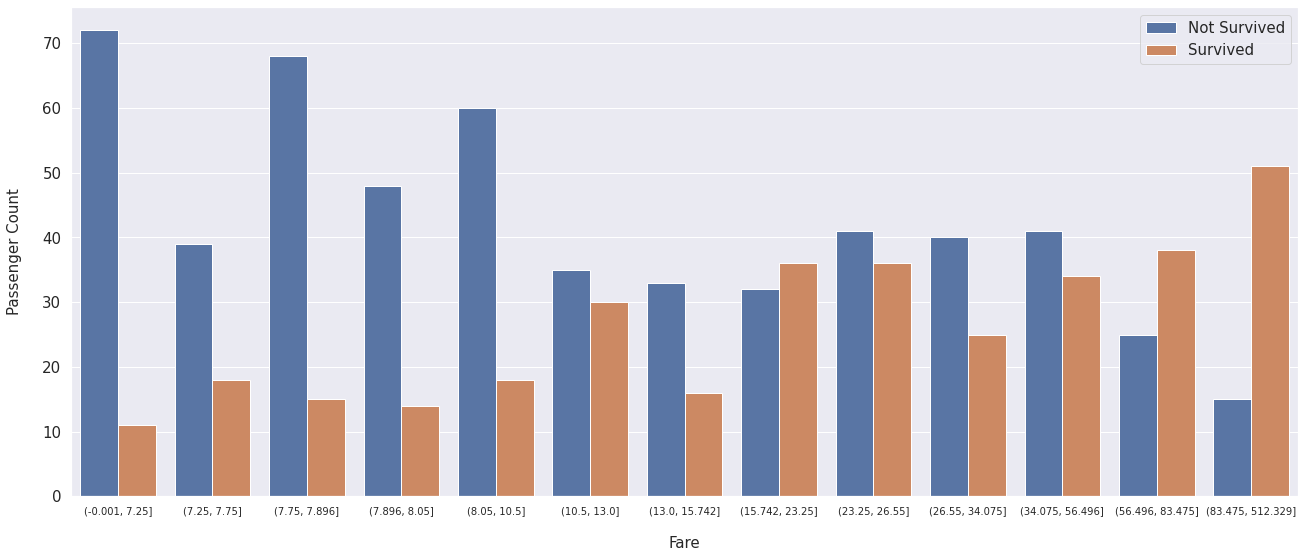

In [32]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})

plt.show()

In [33]:
df_all[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().sort_values(by='Fare', ascending=True)

,Fare,Survived
0,"(-0.001, 7.25]",0.132530
1,"(7.25, 7.75]",0.315789
2,"(7.75, 7.896]",0.180723
3,"(7.896, 8.05]",0.225806
4,"(8.05, 10.5]",0.230769
5,"(10.5, 13.0]",0.461538
6,"(13.0, 15.742]",0.326531
7,"(15.742, 23.25]",0.529412
8,"(23.25, 26.55]",0.467532
9,"(26.55, 34.075]",0.384615


#### Age

In [34]:
df_all.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,22.0,S,"(-0.001, 7.25]",0,1,3,male,1,0.0
1,38.0,C,"(56.496, 83.475]",0,2,1,female,1,1.0
2,26.0,S,"(7.896, 8.05]",0,3,3,female,0,1.0
3,35.0,S,"(34.075, 56.496]",0,4,1,female,1,1.0
4,35.0,S,"(7.896, 8.05]",0,5,3,male,0,0.0


In [35]:
df_all['Age'] = pd.qcut(df_all['Age'], 8)

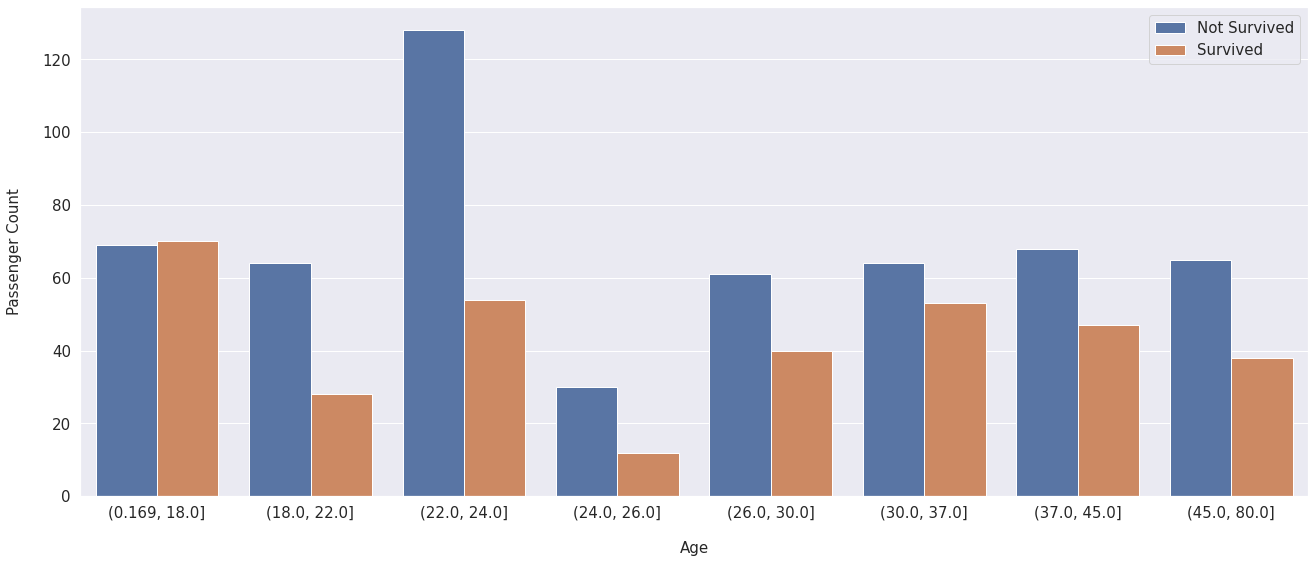

In [36]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})

plt.show()

In [37]:
df_all[['Age', 'Survived']].groupby(['Age'], as_index=False).mean().sort_values(by='Age', ascending=True)

,Age,Survived
0,"(0.169, 18.0]",0.503597
1,"(18.0, 22.0]",0.304348
2,"(22.0, 24.0]",0.296703
3,"(24.0, 26.0]",0.285714
4,"(26.0, 30.0]",0.396040
5,"(30.0, 37.0]",0.452991
6,"(37.0, 45.0]",0.408696
7,"(45.0, 80.0]",0.368932


### Label Encoding Non-Numerical Features

In [38]:
df_train,df_test = df_all.loc[:890], df_all.loc[891:].drop(['Survived'], axis=1)
combine = [df_train,df_test]

combine[0].head(5)

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,"(18.0, 22.0]",S,"(-0.001, 7.25]",0,1,3,male,1,0.0
1,"(37.0, 45.0]",C,"(56.496, 83.475]",0,2,1,female,1,1.0
2,"(24.0, 26.0]",S,"(7.896, 8.05]",0,3,3,female,0,1.0
3,"(30.0, 37.0]",S,"(34.075, 56.496]",0,4,1,female,1,1.0
4,"(30.0, 37.0]",S,"(7.896, 8.05]",0,5,3,male,0,0.0


In [39]:
combine[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Age          891 non-null    category
 1   Embarked     891 non-null    object  
 2   Fare         891 non-null    category
 3   Parch        891 non-null    int64   
 4   PassengerId  891 non-null    int64   
 5   Pclass       891 non-null    int64   
 6   Sex          891 non-null    object  
 7   SibSp        891 non-null    int64   
 8   Survived     891 non-null    float64 
dtypes: category(2), float64(1), int64(4), object(2)
memory usage: 51.8+ KB


In [41]:
non_numeric_features = ['Age', 'Embarked', 'Fare', 'Sex']

for df in combine:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [42]:
combine[0].head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,1,2,0,0,1,3,1,1,0.0
1,6,0,11,0,2,1,0,1,1.0
2,3,2,3,0,3,3,0,0,1.0
3,5,2,10,0,4,1,0,1,1.0
4,5,2,3,0,5,3,1,0,0.0


In [43]:
combine[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          891 non-null    int64  
 1   Embarked     891 non-null    int64  
 2   Fare         891 non-null    int64  
 3   Parch        891 non-null    int64  
 4   PassengerId  891 non-null    int64  
 5   Pclass       891 non-null    int64  
 6   Sex          891 non-null    int64  
 7   SibSp        891 non-null    int64  
 8   Survived     891 non-null    float64
dtypes: float64(1), int64(8)
memory usage: 62.8 KB


### One-Hot Encoding for Nominal Categorical Features

In [44]:
cat_features = ['Pclass', 'Sex', 'Embarked']
encoded_features = []

for df in combine:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([combine[0], *encoded_features[:3]], axis=1)
df_test = pd.concat([combine[1], *encoded_features[3:]], axis=1)

In [45]:
df_train.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3
0,1,2,0,0,1,3,1,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,6,0,11,0,2,1,0,1,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,2,3,0,3,3,0,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,5,2,10,0,4,1,0,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,5,2,3,0,5,3,1,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [46]:
df_test.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3
891,5,1,2,0,892,3,1,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
892,7,2,0,0,893,3,0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
893,7,1,4,0,894,2,1,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
894,4,2,4,0,895,3,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
895,1,2,5,1,896,3,0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


# Conclusion

In [47]:
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
drop_columns = ['Embarked','Pclass','Sex','PassengerId','Survived']
df_all.drop(columns=drop_columns,inplace=True)
df_all.head()

,Age,Embarked_1,Embarked_2,Embarked_3,Fare,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,SibSp
0,1,0.0,0.0,1.0,0,0,0.0,0.0,1.0,0.0,1.0,1
1,6,1.0,0.0,0.0,11,0,1.0,0.0,0.0,1.0,0.0,1
2,3,0.0,0.0,1.0,3,0,0.0,0.0,1.0,1.0,0.0,0
3,5,0.0,0.0,1.0,10,0,1.0,0.0,0.0,1.0,0.0,1
4,5,0.0,0.0,1.0,3,0,0.0,0.0,1.0,0.0,1.0,0


# Model

In [48]:
y_train = df_train['Survived'].values
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_columns))
X_test = StandardScaler().fit_transform(df_test.drop(columns=['Embarked','Pclass','Sex','PassengerId']))

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (891, 12)
y_train shape: (891,)
X_test shape: (418, 12)


## Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
acc_log = round(log_reg.score(X_train,y_train) * 100,2)
acc_log

81.03

## SVM

In [50]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
acc_svc = round(svc.score(X_train,y_train) * 100,2)
acc_svc

82.83

## KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
acc_knn = round(knn.score(X_train,y_train)*100,2)
acc_knn

86.42

## Decision Tree

In [52]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
acc_decision_tree = round(dt.score(X_train,y_train) * 100,2)
acc_decision_tree

92.03

## Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf.score(X_train,y_train)
score = round(rf.score(X_train,y_train) * 100,2)
score

92.03

# HyperParameter Optimization

In [54]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6,7,8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2,3,4,5,6,7,8]

params_dict = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth':max_depth,
                'min_samples_split': min_samples_split, 'min_samples_leaf':min_samples_leaf}

random_search_model = RandomizedSearchCV(rf,params_dict,n_iter=100,n_jobs=-1,verbose=2)
model_tuned = random_search_model.fit(X_train,y_train)

In [55]:
model_tuned.best_params_

In [56]:
from sklearn.ensemble import RandomForestClassifier
rf_tuned = RandomForestClassifier(n_estimators=1600,min_samples_split=6,min_samples_leaf=2,max_features="auto",max_depth=70)
rf_tuned.fit(X_train,y_train)
rf_tuned.score(X_train,y_train)
score = round(rf_tuned.score(X_train,y_train) * 100,2)
score

87.88

## ROC CURVE

In [57]:
from sklearn.metrics import roc_curve, auc
trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train,rf_tuned.predict_proba(X_train)[:,1])
auc_score = auc(trn_fpr,trn_tpr)
auc_score

0.9461461029623238

# Stratified K-Fold Cross Validation

In [64]:
from sklearn.model_selection import StratifiedKFold

N = 5
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
skf = StratifiedKFold(n_splits=5,random_state=5,shuffle=True)

for fold,(train_index,val_index) in enumerate(skf.split(X_train,y_train)):
    print('Fold: ',fold +1)

    rf_tuned.fit(X_train[train_index],y_train[train_index])

    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_index],rf_tuned.predict_proba(X_train[val_index])[:,1])
    val_auc_score = auc(val_fpr, val_tpr)
    
    importances.iloc[:, fold - 1] = rf.feature_importances_

    print("Val Score: ",val_auc_score)


Fold:  1
Val Score:  0.8357707509881422
Fold:  2
Val Score:  0.8937834224598932
Fold:  3
Val Score:  0.8649732620320856
Fold:  4
Val Score:  0.8709893048128342
Fold:  5
Val Score:  0.8659087887249035


# Feature Importance

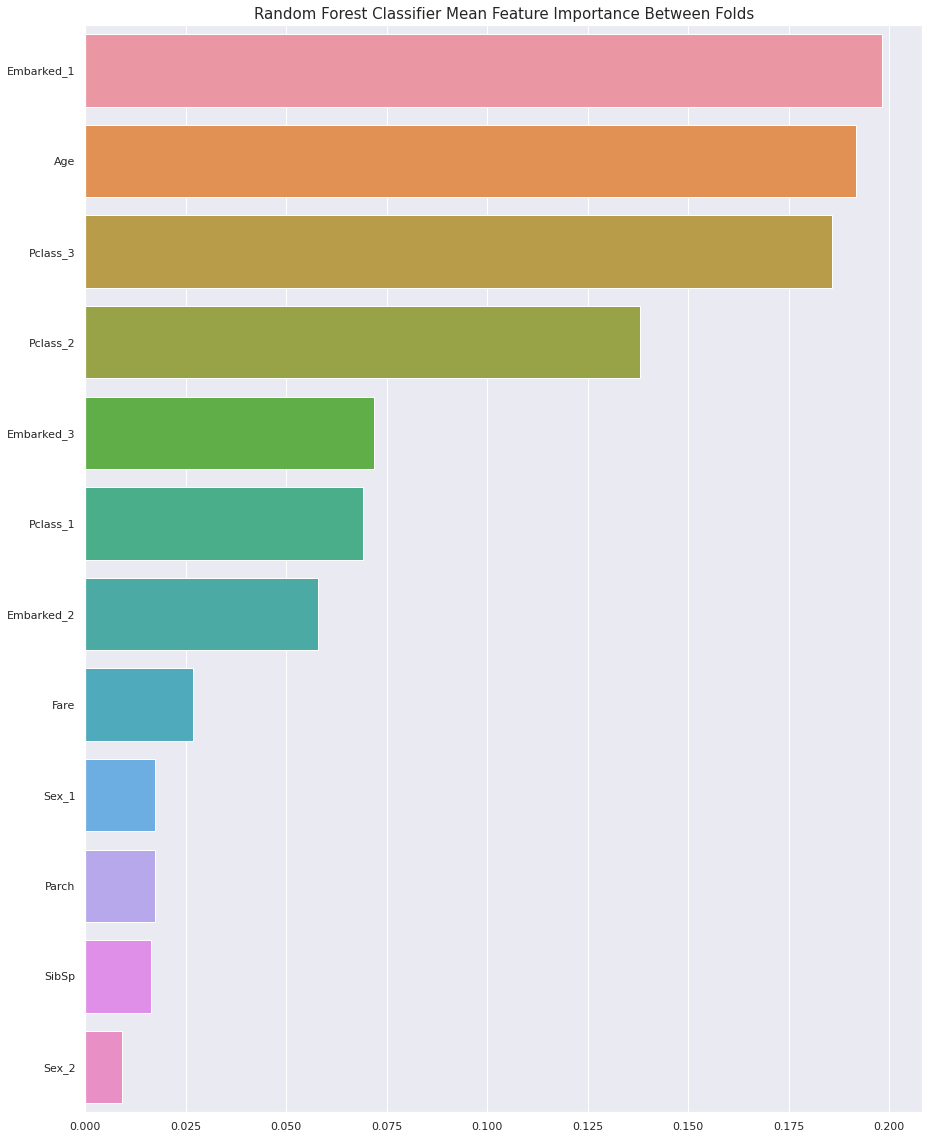

In [67]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

# Ensemble Learning

In [61]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[('svc',svc),('log_reg',log_reg),('knn',knn),('rf',rf)],voting = "hard")
ensemble_model.fit(X_train,y_train)
ensemble_model.score(X_train,y_train)


0.856341189674523

In [62]:
test_df = pd.read_csv("dataset/titanic/test.csv")
y_pred = ensemble_model.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_pred.astype(np.int64)
    })

#submission.to_csv('./submission.csv', index=False)